In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split

import hervpd as hp
import plotReport as pr

In [2]:
df = pd.read_csv( 'data/12features/combined.csv')
df.describe()

,user,AVGNN,SDNN,MeanHR,MinHR,MaxHR,RMSSD,pNNxx,TINN,powerVLF,powerLF,powerHF,ratioHFLF
count,544.000000,544.000000,544.000000,544.00000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000,544.000000
mean,1.187500,758.600000,72.865018,81.37714,67.362033,108.560417,46.409227,20.082227,358.020221,2877.387599,1423.919671,1000.824001,2.753764
std,0.913249,129.785003,32.960406,13.75457,10.849680,36.385572,32.537407,18.316263,146.885899,3619.576847,1443.217366,1841.656665,2.296974
min,0.000000,475.730000,17.833000,51.62800,41.437000,58.117000,4.882500,0.000000,83.000000,85.654000,57.852000,7.977700,0.154680
25%,0.000000,670.362500,51.871500,73.23225,60.292750,91.470250,27.438750,6.593075,258.000000,995.182500,591.307500,258.917500,1.257000
50%,2.000000,750.545000,67.057000,79.94200,66.181500,100.520000,37.994500,15.417500,339.000000,1807.950000,1040.350000,512.090000,2.037350
75%,2.000000,819.307500,85.820000,89.50400,74.285250,112.580000,54.762250,26.790500,426.250000,3304.250000,1697.950000,960.045000,3.579975
max,2.000000,1162.200000,264.250000,126.12000,104.900000,550.320000,240.470000,98.232000,1103.000000,29716.000000,12958.000000,16103.000000,18.228000


Text(0,0.5,'fragments')

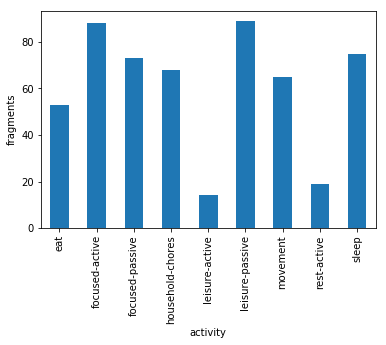

In [36]:
ac = hp.countExamplesByActivity(df)
ax = ac.plot(kind='bar')
ax.set_ylabel("fragments")

In [52]:
# exclude activities with too little representation
df = hp.excludeActivities(df, ['rest-active', 'leisure-active'])
print(df.activity.unique())

['eat' 'focused-active' 'focused-passive' 'household-chores'
 'leisure-passive' 'movement' 'sleep']


In [53]:
movelist = ['exercise-high', 'exercise-low', 'movement', 'household-chores']
df = hp.addPartition(df, movelist, pname='move', labelIn='move', labelOut='still')
    
sleeplist = ['sleep']
df = hp.addPartition(df, sleeplist, pname='sleep', labelIn='sleep', labelOut='wake')

df.head()

,user,activity,posture,AVGNN,SDNN,MeanHR,MinHR,MaxHR,RMSSD,pNNxx,TINN,powerVLF,powerLF,powerHF,ratioHFLF,move,sleep
0,0,eat,sit,-0.588436,0.902062,0.477434,0.313013,0.790589,1.287573,0.485631,0.974303,0.213346,-0.189418,0.202600,-0.834889,still,wake
1,0,eat,sit,-0.853271,1.001970,0.816542,0.572245,1.190566,1.738393,0.690993,1.171917,-0.332523,0.192650,0.841743,-0.909128,still,wake
2,0,eat,sit,-0.696406,-0.057699,0.611476,0.746420,0.561166,0.325057,-0.232206,0.742618,-0.708316,0.324283,-0.278426,0.487191,still,wake
3,0,eat,sit,-0.603552,-0.466139,0.495845,0.516155,-0.207702,-0.115057,-0.583654,-0.163680,-0.688934,-0.103489,-0.302367,0.049779,still,wake
4,0,eat,sit,-1.129675,-0.653931,1.211101,1.422453,0.191449,-0.758294,-0.930140,-0.504394,-0.255621,-0.549369,-0.423032,0.037578,still,wake


### Apply scale to make all features go to mean = 0 and SD = 1. That will allow SVM kernels not to put too much weight on features with larger values.

In [54]:
hp.scaleFeatures(df)
df.describe()

,user,AVGNN,SDNN,MeanHR,MinHR,MaxHR,RMSSD,pNNxx,TINN,powerVLF,powerLF,powerHF,ratioHFLF
count,511.000000,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02,5.110000e+02
mean,1.189824,-9.907274e-17,4.345296e-17,-3.910766e-18,-6.431037e-17,-2.563724e-17,3.823860e-17,-5.431619e-18,7.995344e-17,4.345296e-19,1.260136e-17,5.442483e-17,3.574006e-17
std,0.908119,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00,1.000980e+00
min,0.000000,-2.137055e+00,-1.676670e+00,-2.137750e+00,-2.362415e+00,-1.373772e+00,-1.313777e+00,-1.109950e+00,-1.888086e+00,-7.717804e-01,-9.417885e-01,-5.493034e-01,-1.136800e+00
25%,0.000000,-6.838934e-01,-6.304033e-01,-6.195035e-01,-6.799283e-01,-4.801817e-01,-6.038868e-01,-7.468693e-01,-6.732240e-01,-5.177532e-01,-5.741279e-01,-4.118293e-01,-6.640603e-01
50%,2.000000,-7.328069e-02,-1.541356e-01,-9.631318e-02,-1.142624e-01,-2.201270e-01,-2.565619e-01,-2.462851e-01,-1.135686e-01,-2.944213e-01,-2.761460e-01,-2.664865e-01,-3.093413e-01
75%,2.000000,4.979229e-01,3.897935e-01,5.933614e-01,6.604105e-01,1.002332e-01,2.880550e-01,3.975070e-01,4.631495e-01,1.211459e-01,1.844318e-01,-1.089094e-02,3.844003e-01
max,2.000000,3.075496e+00,5.793283e+00,3.172352e+00,3.393374e+00,1.182139e+01,6.151021e+00,4.306605e+00,5.073482e+00,7.403906e+00,7.882036e+00,8.543813e+00,6.582587e+00


### Test dataset will have 20% of examples, the other 80% will be for training (with cross-validation)

In [55]:
train, test = train_test_split(df, test_size=0.2)
print (len(train), len(test))

408 103


### 3 - Model selection:  Perform an exhaustive search, with k-fold cross-validation,  in the space parameter consisting of:
* $C = 10^{i}, com -1 \leq i \leq 6$, for both linear and RBF kernels
* $\gamma = 10^{i}, com -3 \leq i \leq 3$, for RBF kernel.

In [56]:
crossval = StratifiedShuffleSplit(n_splits=4, test_size=0.2)

c_range = np.logspace(-1, 2, 4) 
gamma_range = np.logspace(-2, 1, 4)

param_lin=dict(C=c_range)
param_rbf=dict(C=c_range, gamma=gamma_range)


In [57]:
grid_lin = GridSearchCV(svm.SVC(kernel='linear', cache_size=1000), param_grid=param_lin, cv=crossval)
grid_lin.fit(X=train.iloc[:, 3:15], y=train['activity'])

print("Kernel linear --- ")
print("Best params: %s with score %0.5f" % (grid_lin.best_params_, grid_lin.best_score_))

clf1 = svm.SVC(kernel='linear', cache_size=1000, C=grid_lin.best_params_['C'])
clf1.fit(X=train.iloc[:, 3:15], y=train['activity'])
print(hp.report(test, clf1.predict(test.iloc[:, 3:15])))

Kernel linear --- 
Best params: {'C': 100.0} with score 0.43598
                  precision    recall  f1-score   support

             eat       0.50      0.33      0.40        15
  focused-active       0.54      0.74      0.62        19
 focused-passive       0.38      0.29      0.33        17
household-chores       0.38      0.38      0.38        16
 leisure-passive       0.28      0.42      0.33        12
        movement       0.57      0.57      0.57        14
           sleep       0.67      0.40      0.50        10

     avg / total       0.47      0.46      0.45       103



In [58]:
grid_rbf = GridSearchCV(svm.SVC(kernel='rbf', cache_size=1000), param_grid=param_rbf, cv=crossval)
grid_rbf.fit(X=train.iloc[:, 3:15], y=train['activity'])

print("Kernel RBF --- ")
print("Best params: %s with score %0.5f" % (grid_rbf.best_params_, grid_rbf.best_score_))

clf2 = svm.SVC(kernel='rbf', cache_size=1000, C=grid_rbf.best_params_['C'], gamma=grid_rbf.best_params_['gamma'])
clf2.fit(X=train.iloc[:, 3:15], y=train['activity'])
r_fulldf = hp.report(test, clf2.predict(test.iloc[:, 3:15]))
print(r_fulldf)

Kernel RBF --- 
Best params: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.50305
                  precision    recall  f1-score   support

             eat       0.33      0.20      0.25        15
  focused-active       0.62      0.68      0.65        19
 focused-passive       0.42      0.29      0.34        17
household-chores       0.35      0.44      0.39        16
 leisure-passive       0.30      0.58      0.40        12
        movement       0.44      0.29      0.35        14
           sleep       0.78      0.70      0.74        10

     avg / total       0.46      0.45      0.44       103



[0.33, 0.2, 0.25]
[0.62, 0.68, 0.65]
[0.42, 0.29, 0.34]
[0.35, 0.44, 0.39]
[0.3, 0.58, 0.4]
[0.44, 0.29, 0.35]
[0.78, 0.7, 0.74]


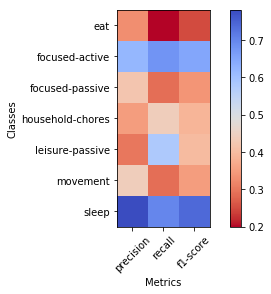

In [59]:
pr.plot_classification_report(r_fulldf, title='', with_avg_total=False, cmap=plt.cm.coolwarm_r)

In [60]:
clf3 = svm.SVC(kernel='poly', cache_size=1000, C=grid_lin.best_params_['C'])
clf3.fit(X=train.iloc[:, 3:15], y=train['activity'])
print(hp.report(test, clf3.predict(test.iloc[:, 3:15])))

                  precision    recall  f1-score   support

             eat       0.33      0.13      0.19        15
  focused-active       0.46      0.58      0.51        19
 focused-passive       0.33      0.18      0.23        17
household-chores       0.40      0.38      0.39        16
 leisure-passive       0.27      0.67      0.38        12
        movement       0.55      0.43      0.48        14
           sleep       0.88      0.70      0.78        10

     avg / total       0.44      0.42      0.41       103




## Now, we can run the same steps above with multiple experiments! Time to have fun!!

In [63]:
r = hp.runFlow(df)

408 train examples and 103 test examples
Best params for linear kernel: {'C': 100.0} with score 0.42683
--- test results for linear kernel:
                  precision    recall  f1-score   support

             eat       0.29      0.13      0.18        15
  focused-active       0.61      0.61      0.61        18
 focused-passive       0.24      0.36      0.29        14
household-chores       0.55      0.35      0.43        17
 leisure-passive       0.20      0.42      0.27        12
        movement       0.67      0.43      0.52        14
           sleep       0.58      0.54      0.56        13

     avg / total       0.46      0.41      0.42       103

Best params for RBF kernel: {'C': 10.0, 'gamma': 0.10000000000000001} with score 0.50000
--- test results for RBF kernel:
                  precision    recall  f1-score   support

             eat       0.50      0.20      0.29        15
  focused-active       0.43      0.50      0.46        18
 focused-passive       0.20      0.21 

[0.5, 0.2, 0.29]
[0.43, 0.5, 0.46]
[0.2, 0.21, 0.21]
[0.5, 0.41, 0.45]
[0.33, 0.75, 0.46]
[0.43, 0.21, 0.29]
[0.77, 0.77, 0.77]


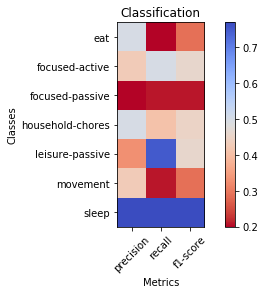

In [64]:
pr.plot_classification_report(r[1], cmap=plt.cm.coolwarm_r)

C:\Users\Ju\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


136 train examples and 35 test examples
Best params for linear kernel: {'C': 1.0} with score 0.41071
--- test results for linear kernel:
                  precision    recall  f1-score   support

             eat       1.00      0.50      0.67         2
  focused-active       0.00      0.00      0.00         0
 focused-passive       0.71      0.62      0.67         8
household-chores       0.33      0.50      0.40         6
 leisure-passive       0.57      0.80      0.67         5
        movement       0.75      0.50      0.60         6
           sleep       1.00      0.62      0.77         8

     avg / total       0.72      0.60      0.63        35



C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Best params for RBF kernel: {'C': 100.0, 'gamma': 0.01} with score 0.57143
--- test results for RBF kernel:
                  precision    recall  f1-score   support

             eat       0.00      0.00      0.00         2
  focused-active       0.00      0.00      0.00         0
 focused-passive       0.83      0.62      0.71         8
household-chores       0.36      0.67      0.47         6
 leisure-passive       0.57      0.80      0.67         5
        movement       1.00      0.50      0.67         6
           sleep       1.00      0.62      0.77         8

     avg / total       0.73      0.60      0.63        35

                  precision    recall  f1-score   support

             eat       1.00      0.50      0.67         2
  focused-active       0.00      0.00      0.00         0
 focused-passive       0.71      0.62      0.67         8
household-chores       0.33      0.50      0.40         6
 leisure-passive       0.57      0.80      0.67         5
        movement  

C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


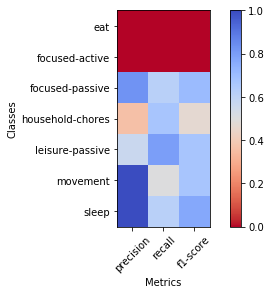

In [68]:
u0 = hp.userRows(df, 0)
r0 = hp.runFlow(u0)
print (r0[0])
print (r0[1])
pr.plot_classification_report(r0[1], title ='')


In [ ]:
r1 = hp.runFlow(hp.userRows(df, 1))
print (r1[0])
print (r1[1])
pr.plot_classification_report(r1[1], title ='')

In [ ]:
r2 = hp.runFlow(hp.userRows(df, 2))
print (r2[0])
print (r2[1])
pr.plot_classification_report(r2[1], title ='')

In [ ]:
pr.plot_classification_report(reports[2][1], title='', cmap=plt.cm.coolwarm_r)

In [ ]:
hp.countExamplesByActivity(df)

### 2 - Is eating the problem??

In [ ]:
df_reduced = hp.excludeActivities(df, ['eat'])
df_reduced.groupby('activity').count()['user']

In [ ]:
reduced = hp.runFlow(df_reduced)

In [ ]:
reduced = hp.runFlowByUser(df_reduced)

# Defining hierarchy

### 1 - Splitting database into movement categories (movement, household chores and exercise) and all others

In [7]:
df.groupby('move').count()['user']

move
move     133
still    378
Name: user, dtype: int64

In [9]:
mvres = hp.runFlow(df, labelName='move')

C:\Users\Ju\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Ju\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


408 train examples and 103 test examples
Best params for linear kernel: {'C': 1.0} with score 0.85366
--- test results for linear kernel:
             precision    recall  f1-score   support

       move       0.95      0.67      0.78        30
      still       0.88      0.99      0.93        73

avg / total       0.90      0.89      0.89       103

Best params for RBF kernel: {'C': 1.0, 'gamma': 0.01} with score 0.90244
--- test results for RBF kernel:
             precision    recall  f1-score   support

       move       0.95      0.63      0.76        30
      still       0.87      0.99      0.92        73

avg / total       0.89      0.88      0.88       103



In [ ]:
pr.plot_classification_report(mvres[0])

In [ ]:
mvresu = hp.runFlowByUser(df_move, labelName='move')

In [ ]:
scores = []
for i in mvresu:
    scores.append(pr.fscore_from_report(i)) 
print(scores)

### 1 - Split data by movement intensity:
 * group 1 = movement, household chores, exercise
 

In [ ]:
df_stillcls = hp.excludeActivities(df, movelist)
hp.countExamplesByActivity(df_stillcls)

In [ ]:
hp.runFlow(df_stillcls)

In [ ]:
hp.runFlowByUser(df_stillcls)

In [ ]:
df_movecls = hp.filterActivities(df, includelist)
hp.countExamplesByActivity(df_movecls)

In [ ]:
hp.runFlow(df_movecls)

In [ ]:
ju_move = hp.userRows(df_movecls, 0)
print(hp.countExamplesByActivity(ju_move))
hp.runFlow(ju_move)

In [ ]:
edu_move = hp.userRows(df_movecls, 2)
print(hp.countExamplesByActivity(edu_move))
hp.runFlow(edu_move)

In [ ]:
for activ in df_stillcls.activity.unique():
    print ('----------------------------------------------------------------')
    dfa = df_stillcls
    df_onevsall = hp.addPartition(df=dfa, includelist=[activ], pname=activ, labelIn=activ, labelOut='others')
    print(df_onevsall.groupby(activ).count()['user'])
    hp.runFlow(df_onevsall, labelName=activ)

### Split still activities by sleep vc others

In [ ]:
hp.countExamplesByActivity(df_stillcls)
df_partsleep = hp.addPartition(df=df_stillcls, includelist=['sleep'], pname='sleep', labelIn='sleep', labelOut='wake')
print(df_partsleep.groupby('sleep').count()['user'])

In [ ]:
 hp.runFlow(df_partsleep, labelName='sleep')

In [ ]:
ju_sleep = hp.userRows(df_partsleep, 0) 
hp.runFlow(ju_sleep, labelName='sleep')

In [ ]:
edu_sleep = hp.userRows(df_partsleep, 2) 
hp.runFlow(edu_sleep, labelName='sleep')

In [ ]:
df_wake = hp.excludeActivities(df_stillcls,['sleep'] )
hp.countExamplesByActivity(df_wake)

In [ ]:
hp.runFlow(df_wake)

In [ ]:
hp.runFlowByUser(df_wake)

### Split by passive vs active sitting activities

In [ ]:
df_actlvl = hp.addPartition(df_wake, includelist=['focused-passive', 'leisure-passive'], pname='actlvl', labelIn='passive', labelOut='active')
print(df_passive.groupby('actlvl').count()['user'])

In [ ]:
hp.runFlow(df_actlvl, labelName='actlvl')

In [ ]:
hp.runFlowByUser(df_actlvl, labelName='actlvl')

In [ ]:
df_passive = hp.filterActivities(df_actlvl, ['leisure-passive', 'focused-passive'])
hp.countExamplesByActivity(df_passive)

In [ ]:
hp.runFlow(df_passive)

In [ ]:
hp.runFlow(hp.userRows(df_passive, 0))

In [ ]:
hp.runFlow(hp.userRows(df_passive, 2))

In [ ]:
df_active = hp.excludeActivities(df_actlvl, ['leisure-passive', 'focused-passive'])
hp.countExamplesByActivity(df_active)

In [ ]:
hp.runFlow(df_active)

In [ ]:
hp.runFlowByUser(df_active)